In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/graduates-admission-prediction/admission_data.csv


In [2]:
df=pd.read_csv('/kaggle/input/graduates-admission-prediction/admission_data.csv')

In [3]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65


In [4]:
df.shape

(500, 8)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   GRE Score          500 non-null    int64  
 1   TOEFL Score        500 non-null    int64  
 2   University Rating  500 non-null    int64  
 3   SOP                500 non-null    float64
 4   LOR                500 non-null    float64
 5   CGPA               500 non-null    float64
 6   Research           500 non-null    int64  
 7   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 31.4 KB


In [6]:
df.isnull().sum()

GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

In [7]:
df.columns

Index(['GRE Score', 'TOEFL Score', 'University Rating', 'SOP', 'LOR ', 'CGPA',
       'Research', 'Chance of Admit '],
      dtype='object')

<Axes: >

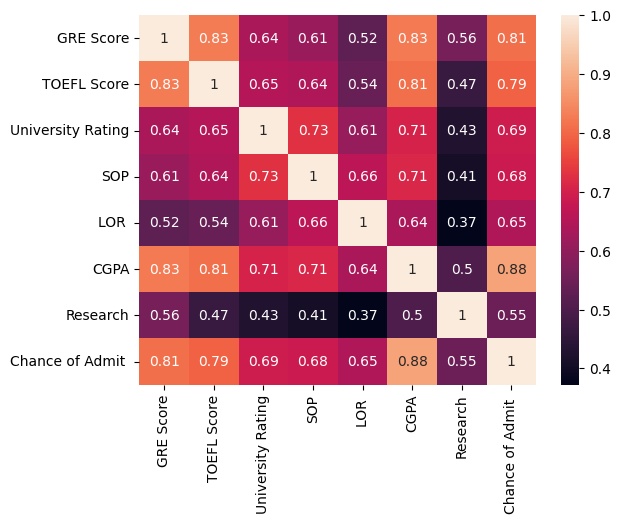

In [8]:
import seaborn as sns
sns.heatmap(df.corr(),annot=True)

<Axes: ylabel='CGPA'>

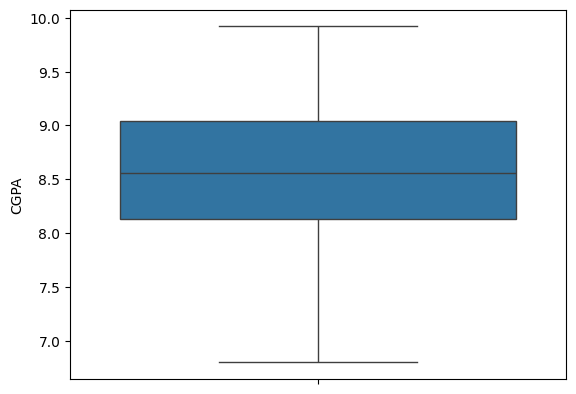

In [9]:
sns.boxplot(df['CGPA'])

In [10]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]

In [11]:
x.shape

(500, 7)

In [12]:
y.shape

(500,)

In [14]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
x=scaler.fit_transform(x)

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [18]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense
import keras_tuner as kt

In [51]:
def build_model(hp):
    model=Sequential()
    units=hp.Int('units',min_value=8,max_value=128,step=1)
    optimizer=hp.Choice('optimizer',values=['adam','sgd','rmsprop','adadelta'])
    model.add(Dense(units=units,activation='relu',input_shape=(x_train.shape[1],)))
    for i in range(hp.Int('num_layers',min_value=1,max_value=10)):
        model.add(Dense(units=units,activation='relu'))

    model.add(Dense(units=1,activation='linear'))

    model.compile(optimizer=optimizer,loss='mse')

    return model
    

In [56]:
tuner=kt.RandomSearch(build_model,objective='val_loss',max_trials=5,directory='mydir1',project_name='num_layers1')


Reloading Tuner from mydir1/num_layers1/tuner0.json


In [57]:
tuner.search(x_train,y_train,epochs=5,validation_data=(x_test,y_test))

Trial 5 Complete [00h 00m 03s]
val_loss: 0.013321038335561752

Best val_loss So Far: 0.004433286841958761
Total elapsed time: 00h 00m 39s


In [58]:
tuner.get_best_hyperparameters()[0].values

{'units': 117, 'optimizer': 'adam', 'num_layers': 7}

In [60]:
model=tuner.get_best_models(num_models=1)[0]

In [61]:
model.fit(x_train,y_train,batch_size=32,epochs=300,initial_epoch=6,validation_data=(x_test,y_test))

Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step - loss: 0.0167 - val_loss: 0.0069
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0061 - val_loss: 0.0048
Epoch 9/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0041 - val_loss: 0.0047
Epoch 10/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 11/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0027 - val_loss: 0.0040
Epoch 12/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0024 - val_loss: 0.0035
Epoch 13/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - val_loss: 0.0039
Epoch 14/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0018 - val_loss: 0.0038
Epoch 15/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0021 - val_loss: 0.0044
Epoch 16/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0023 - val_loss: 0.0040
Epoch 17/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0019 - val_loss: 0.0040
Epoch 18/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

In [62]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 117)            │           936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 117)            │        13,806 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           118 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 293,090 (1.12 MB)

 Trainable params: 97,696 (381.62 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 195,394 (763.26 KB)

In [63]:
sample=[[337,118,4,4.5,4.5,9.65,1]]
sample=scaler.transform(sample)
y_pred=model.predict(sample)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


In [64]:
y_pred

array([[0.66932666]], dtype=float32)

In [36]:
df.head()

,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,337,118,4,4.5,4.5,9.65,1,0.92
1,324,107,4,4.0,4.5,8.87,1,0.76
2,316,104,3,3.0,3.5,8.00,1,0.72
3,322,110,3,3.5,2.5,8.67,1,0.80
4,314,103,2,2.0,3.0,8.21,0,0.65
